# Stacking集成学习算法

## 1 知识梳理

### 1.1 Stacking集成学习思路
1. 将数据按照一定比例划分为训练集和测试集
2. 创建第一层的多个同质或异质模型
3. 使用5折交叉验证对第一层模型进行训练，然后将在验证集得到训练结果$A$，在测试集得到的训练结果$B$
4. 基于验证集的训练结果$A$，使用LR模型进行训练，建立LR模型
5. 使用训练好的LR模型对测试集的训练结果$B$进行预测，得到最终的预测类别或概率，作为整个测试集的结果

![jupyter](../assets/ch05/5.png) 

### 1.2 Stacking与Blending对比
||Blending|Stacking|
|:--|:-:|:-:|
|算法|方法简单|方法复杂，需要进行K折交叉验证|
|稳定性|可能会过拟合|使用多次CV会比较稳健|
|数据使用情况|使用一部分数据进行模型验证|使用全部的训练集数据|

## 2 实战练习

关于Stacking算法，本例中使用`mlxtend.StackingCVClassifier`

In [1]:
from sklearn import datasets

# 加载鸢尾花数据集
iris = datasets.load_iris()
# 取sepal width (cm)、petal length (cm)列的数据
X, y = iris.data[:, 1:3], iris.target

### 2.1 StackingCVClassifier参数

- classifiers ：array，shape=[n_classifiers]  
  &emsp;&emsp;分类器列表。在StackingCVClassifer上使用`fit`方法将调用这些分类器的`fit`方法，这些分类器使用`clone`方法将存储在`class`属性中`self.clfs_`。


- meta_classifier ：object  
  &emsp;&emsp;设置元分类器，作为Stacking算法中的第二层模型。


- use_probas ：bool（默认：False）  
  &emsp;&emsp;如果为`True`，则使用预测的概率而不是类别标签训练元分类器。


- drop_proba_col ：string（默认值：无）  
  &emsp;&emsp;在特征列中删除多余的“概率”列，主要用于特征列具有多重共线性的元分类器，如果为`last`，则删除最后一列。如果为`first`，则删除第一列。仅在`use_probas=True`时可用。


- cv ：int，cross-validation generator or an iterable（可选，默认值：2）  
  &emsp;&emsp;确定交叉验证拆分策略。cv的可能输入是：
    - `None`，使用默认的2折交叉验证
    - `int`，指定折叠次数(Stratified)KFold
    - 用作交叉验证生成器的可迭代对象
    - 训练/测试集划分的迭代器  
  对于`int`/`None`，根据`stratify`参数选择使用KFold或StratifiedKFold进行交叉验证。


- shuffle ：bool（默认：True）  
  &emsp;&emsp;如果为True，且`cv`参数为`int`，则将在交叉验证之前的拟合阶段对训练数据进行混洗。如果`cv`参数是指定的交叉验证，则忽略此参数的配置。


- random_state ：int，RandomState实例或`None`，可选（默认值：`None`）  
  &emsp;&emsp;控制交叉验证拆分的随机，仅在`cv`为整数且`shuffle=True`时可用


- stratify ：bool（默认：True）  
  &emsp;&emsp;如果为`True`，且`cv`参数为整数，则将采用分层的K折交叉验证。如果cv参数是指定的交叉验证，则忽略此参数的配置。


- verbose ：int，可选（默认=0）  
  &emsp;&emsp;控制训练过程中的日志打印情况。
  - verbose=0（默认）：不打印任何内容
  - verbose=1：打印训练的回归模型编号和名称，以及当前正在训练的交叉验证`fold`方式
  - verbose=2：打印训练的回归模型的参数信息
  - verbose>2：修改基础回归模型的verbose参数为`self.verbose-2`


- use_features_in_secondary ：bool（默认：False）  
  &emsp;&emsp;如果为True，则将根据原分类器的预测值和原数据集，对元分类器进行训练。如果为False，则仅根据原分类器的预测值来训练元分类器。


- store_train_meta_features ：bool（默认：False）  
  &emsp;&emsp;如果为True，则将元分类器训练数据计算出的元特征存储在`self.train_meta_features_`数组中，可以在构建后，使用`fit`函数进行调用。


- use_clones ：bool（默认：True）  
  &emsp;&emsp;如果为True（默认），则对分类器使用`clone`方法，否则将使用原始的分类器，并在调用`fit`方法时将其重新在数据集上训练。因此，如果`use_clones=True`，则在使用`StackingCVClassifier`的`fit`方法时，原始输入的分类器将保持不变。如果您正在使用支持scikit-learn拟合/预测API接口但与scikit-learn的clone功能不兼容的估算器，推荐配置`use_clones=False`。


- n_jobs ：int或None（可选）（默认为None）  
  &emsp;&emsp;用于设置计算时的CPU数量。`None`表示1，-1表示使用所有CPU。


- pre_dispatch ：int或字符串，可选  
  &emsp;&emsp;控制在并行执行期间调度的作业数。当调度的作业数量超过CPU的处理能力时，减少此数量可能有助于避免内存消耗激增。此参数可以是：
  - None，在这种情况下，所有作业都将立即创建并产生。将其用于轻量级和快速运行的作业，以避免由于按需生成作业而导致的延迟
  - int，给出所产生的总作业的确切数量

### 2.2 使用3折CV验证Stacking分类器与单分类器的效果对比

In [2]:
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
RANDOM_SEED = 42

# 第一层分类器
knn_clf = KNeighborsClassifier(n_neighbors=1)
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
nb_clf = GaussianNB()
# 第二层分类器
lr = LogisticRegression()

# Stacking，默认使用2折交叉验证拆分
stacking_clf = StackingCVClassifier(classifiers=[knn_clf, rf_clf, nb_clf],
                                    meta_classifier=lr,
                                    random_state=RANDOM_SEED)

In [4]:
print('3-fold cross validation:\n')

# 使用3折交叉验证将4个分类器的效果进行对比
for clf, label in zip([knn_clf, rf_clf, nb_clf, stacking_clf], ['KNN', 'Random Forest', 'Naive Bayes', 'StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" %
          (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


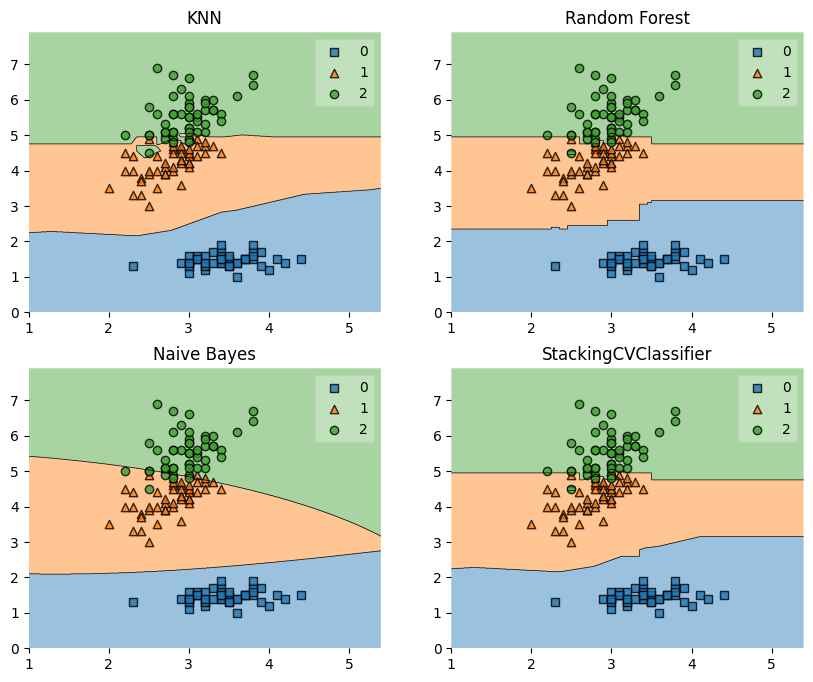

In [5]:
# 调用plot_decision_regions方法绘制决策边界

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.pyplot as plt

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))
for clf, lab, grd in zip([knn_clf, rf_clf, nb_clf, stacking_clf],
                         ['KNN',
                          'Random Forest',
                          'Naive Bayes',
                          'StackingCVClassifier'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

### 2.3 使用概率作为元特征

In [6]:
# 第一层分类器
knn_clf = KNeighborsClassifier(n_neighbors=1)
rf_clf = RandomForestClassifier(random_state=1)
nb_clf = GaussianNB()
# 第二层分类器
lr = LogisticRegression()

# Stacking，默认使用2折交叉验证拆分，使用概率作为元特征
stacking_clf = StackingCVClassifier(classifiers=[knn_clf, rf_clf, nb_clf],
                                    use_probas=True,
                                    meta_classifier=lr,
                                    random_state=42)

In [7]:
print('3-fold cross validation:\n')

# 使用3折交叉验证将4个分类器的效果进行对比
for clf, label in zip([knn_clf, rf_clf, nb_clf, stacking_clf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y,
                             cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


### 2.4 使用5折CV验证，并使用网格搜索进行调参优化

In [8]:
from sklearn.model_selection import GridSearchCV

# 第一层分类器
knn_clf = KNeighborsClassifier(n_neighbors=1)
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
nb_clf = GaussianNB()
# 第二层分类器
lr = LogisticRegression()

# Stacking，默认使用2折交叉验证拆分
stacking_clf = StackingCVClassifier(classifiers=[knn_clf, rf_clf, nb_clf],
                                    meta_classifier=lr,
                                    random_state=42)

In [9]:
# 各个分类器的参数
params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

# 网格搜索
grid = GridSearchCV(estimator=stacking_clf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

# 得到每个参数组合Stacking分类器的效果
# for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#     print("%0.3f +/- %0.2f %r"
#           % (grid.cv_results_[cv_keys[0]][r],
#              grid.cv_results_[cv_keys[1]][r] / 2.0,
#              grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
Accuracy: 0.95


In [10]:
stacking_clf = StackingCVClassifier(classifiers=[knn_clf, knn_clf,  rf_clf, nb_clf],
                                    meta_classifier=lr,
                                    random_state=RANDOM_SEED)

# 如果使用多次回归算法，需要在参数网格中添加一个附加的数字后缀
params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=stacking_clf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

# for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#     print("%0.3f +/- %0.2f %r"
#           % (grid.cv_results_[cv_keys[0]][r],
#              grid.cv_results_[cv_keys[1]][r] / 2.0,
#              grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
Accuracy: 0.96


### 2.5 通过选择不同的第1层分类器训练不同的特征列数据

In [11]:
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline

iris = datasets.load_iris()
X = iris.data
y = iris.target

# 采用ColumnSelector方法，选择特征列数据
pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

stacking_clf = StackingCVClassifier(classifiers=[pipe1, pipe2],
                                    meta_classifier=LogisticRegression(),
                                    random_state=42)

stacking_clf.fit(X, y)

scores = cross_val_score(stacking_clf, X, y,
                         cv=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]"
      % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.02) [StackingClassifier]


### 2.6 绘制ROC曲线

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle

iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target

# 进行二值化
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

RANDOM_SEED = 42

In [13]:
# 划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

In [14]:
# 第一层分类器
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
svc_clf = SVC(random_state=RANDOM_SEED)
# 第二层分类器
lr = LogisticRegression()

# Stacking，默认使用2折交叉验证拆分
stacking_clf = StackingCVClassifier(classifiers=[lr_clf, rf_clf, svc_clf],
                                    meta_classifier=lr)

# Stacking多分类
classifier = OneVsRestClassifier(stacking_clf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

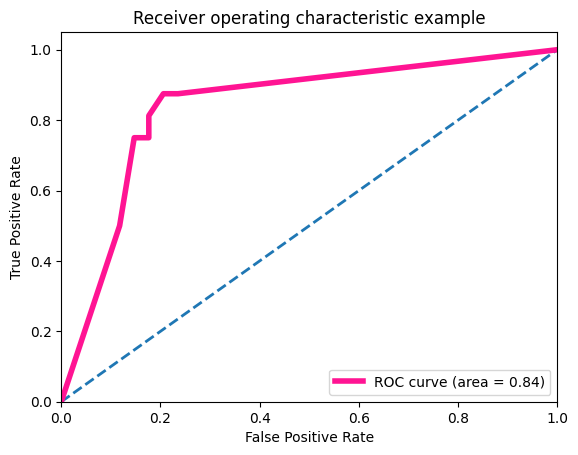

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均的ROC曲线和绘制ROC曲线图
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')

plt.plot(fpr[2], tpr[2], color='deeppink', lw=4,
         label='ROC curve (area = %0.2f)' % roc_auc[2])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()